## **Problem statement**

*10 years after the biggest housing and financial crises of our generation, real-estate is again starting to produce noticable yearly price gains. Some Tier 1 cities such as New York and San Francisco have already seen their housing prices break new highs and become unaffordable for most locals. Even some Tier 2 cities have joined the party fueled by low interest rates and become overbought according to conventional real-estate metrics.   
A real- estate investment fund, known for its sound investing philosophy based on market fundamentals, has therefore hired us to develop a model that can accurately price houses in Tier 3 cities with which they were up-to-now unfamiliar with. According the them, the Tier 3 cities such as Ames, IA still provide good rental yields and make sense as investments from fundamental investing point of view. If the pricing model for Ames proves accurate and usable, the plan is to roll it out for Tier 3 citis nationwide.
Another key deliverable in addition to a simple, interpretable model that prices houses in Ames would be a set of quantifiable factors determining those prices. As the goal of the fund is to maximize profits, they would need to know, once they buy a house, which features to invest in or upgrade in order to maximize the houses value before it is sold.*

<a id = "Content"><a/>
### Content
- [1.0 Import, functions, data loading](#1.0)
- [2.0 Linear regression](#2.0)
    - [2.1 Lin reg - dummify neighborhoods](#2.1)
    - [2.2 Lin reg - undo deck/bsmnt transformations](#2.2)
- [3.0 K-folds cross-validation](#3.0)
- [4.0 Ridge regression](#4.0)
- [5.0 Lasso regression](#5.0)
- [6.0 Wrapper method search](#6.0)
    - [6.1 Drop 9 features](#6.1)
    - [6.2 Ridge and Lasso without 9 features](#6.2)
    - [6.3 Drop 2, 3 and 4 features](#6.3)
    - [6.4 Add back the 'yr_sold' column](#6.4)
    - [6.5 Models summary](#6.5)
- [7.0 Kaggle submissions](#7.0)
    - [7.1 Kaggle submission No 1](#7.1)
    - [7.2 Kaggle submission No 2](#7.2)
    - [7.3 Kaggle submission No 3](#7.3)
- [8.0 Model for Presentation](#8.0)
    - [8.1 Value-added per house feature](#8.1)
- [9.0 Outcomes and conclusions](#9.0)

<a id = '1.0'><a/>
### 1.0 Import, functions, data loading
* [Back to top](#Content)

In [1]:
# Import libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import itertools
import random

plt.style.use('fivethirtyeight')
sns.set(style = 'white')

In [2]:
def optimal_features(n):
    """finds all the possible combinations with of n number of features and return the list
    of features that had the highest r2 in ames dataset
    """
    # create all the possible n-feature combinations
    features2 = list(itertools.combinations(X.columns, n))
    # sometimes the number of combinations can be in 10s of millions. check no more than
    # 50 thousand ( this will only affect the 20-feature search. when we drop 2, 3, 4 features,
    # the number of combinations is below 50 thousand)
    if len(features2) > 50000:
        features2 = random.sample(features2, 50000)
        
    r2max = 0 # set max r2 to zero
    for i in features2:
        Xtrain2 = Xtrain[list(i)] # make new feature list for the train and test set
        Xtest2 = Xtest[list(i)]
        model = LinearRegression().fit(Xtrain2, ytrain) #run a model based on the latest featues
        if float(model.score(Xtest2, ytest)) > r2max: # if the r2 is the highest so far...
            r2max = model.score(Xtest2, ytest) # reset the highest r2
            best_f = list(i) # and reset the best feature list
    #         best = zip(i,model.coef_) # and reset the best coefficients
    print('best r2 is: ', round(r2max, 4), '\n')
    print(f'best {n}-feature group is:  {best_f}')
    display('discarded features are: ', set(X.columns)-set(best_f))
    return best_f
    # display('coef are: ', list(best))

In [3]:
def display_all(df):
    '''temporarily increase display max and transpose the dateframe view
    for enhanced readability
    '''
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        display(df.head(40).transpose())

In [4]:
def resid_hgram(y_test, y_score):
    # calculate the residuals
    resid = np.exp(y_test) - np.exp(y_score)
    #plot histogram
    sns.displot(resid)
    plt.title('Residual Histogram',fontsize=14, color='darkgoldenrod')
    plt.xlabel('Residual value',fontsize=12, color='darkgoldenrod')
    plt.ylabel('Frequency', fontsize=12, color='darkgoldenrod')
    


In [5]:
#add values to the barchart
def addlabels(x,y):
    """ given x (feature names) and y (their values), addlabels 
    adds brightly-colored values to a horizontal bar chart
    """
    for i in range(len(x)):
        plt.text(y[i], i, round(y[i]), va = 'center',bbox = dict(facecolor = 'chartreuse',
                                                                 alpha =.8))

In [125]:
# create horizontal bar chart from a portion of rows
def partial_hbar(lst, ylabel):
    """ lst - is a portion of dataframe's (pm) rows from which horizontal barplot 
    is to be created
        ylabel - ylabel for the hbar plot
    """
    pm_temp = pm[[pm.iloc[i]['feature'] in lst for i in range(len(pm))]]
    plt.figure(figsize = (8, 5))
    sns.barplot(data = pm_temp, y='feature', x='value_added', orient = 'h')
    addlabels(pm_temp['feature'].reset_index(drop=True), pm_temp['value_added'].
              reset_index(drop=True))
    plt.title("Value added per feature", fontsize=14, color='darkgoldenrod')
    plt.xlabel("Value added ($)", fontsize=12, color='darkgoldenrod')
    plt.ylabel(ylabel, fontsize=13, color='darkgoldenrod')
    plt.show()

In [7]:
# read in the transformed datasets
ames = pd.read_csv('../datasets/train_cat&num_clean.csv')
ames2 = pd.read_csv('../datasets/test_cat&num_clean.csv')

In [8]:
ames.head()

,lotarea,neighborhood,overallqual,overallcond,totalbsmtsf,grlivarea,kitchenqual,paveddrive,yrsold,saleprice,...,cncrt_found,bsmt_ord,heatingqc_dum,cent_air_dum,garage_ord,fireplace_ord,lotfrontage_imp,remodel_age,tot_bath,deckporcharea
0,9.511703,1,6,8,6.587550,7.299121,2,1,2010,11.779129,...,0,2.75,1,1,1.67,0.0,81.889336,6,2.5,3.806662
1,9.349406,3,7,5,6.817831,7.660114,2,1,2009,12.301383,...,1,3.00,1,1,1.67,1.0,43.000000,14,3.5,4.317488
2,8.977399,1,5,7,6.964136,6.963190,2,1,2010,11.599103,...,0,2.75,0,1,0.67,0.0,68.000000,4,2.0,3.970292
3,9.190342,3,5,5,5.953243,7.275172,1,1,2010,12.066811,...,1,2.00,0,1,2.00,0.0,73.000000,4,2.5,4.615121
4,9.563459,3,6,8,6.517671,7.275865,1,0,2010,11.838626,...,1,1.75,0,1,1.00,0.0,82.000000,18,2.0,4.094345


In [9]:
ames.shape

(2043, 30)

In [10]:
# temporarily drop yrsold column by saving it to a variable yr and yr2
yr = ames[['yrsold']]
yr2 = ames2[['yrsold']]
ames.drop('yrsold', axis=1, inplace=True)
ames2.drop('yrsold', axis=1, inplace=True)

In [11]:
# make sure no null values before models are run
print(ames.isnull().sum().sum())
print(ames2.isnull().sum().sum())

0
0


<a id = '2.0'><a/>
### 2.0 Linear regression
* [Back to top](#Content)

In [12]:
#train, test, split
X = ames.drop('saleprice', axis=1)
y = ames['saleprice']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)



In [13]:
X.shape

(2043, 28)

In [14]:
# first, run a baseline model, by inserting the mean house price for every prediction. rmse
# will be the benchmark versus which we'll be able to tell if our models adds value (the lower
# the better)
ave = np.exp(ytrain.mean())
yhat = [ave]*len(ytest)
print('Baseline model r2 (should be zero)', round(r2_score(np.exp(ytest), yhat),4))
print('Baseline model rmse', round(mean_squared_error(np.exp(ytest), yhat, squared=False)))

Baseline model r2 (should be zero) -0.0241
Baseline model rmse 81570


In [15]:
# run Lin Reg
lr_base = LinearRegression().fit(Xtrain, ytrain)
#predict values
yhat = lr_base.predict(Xtest)

print('r2 from train data', round(lr_base.score(Xtrain, ytrain), 3))
print('r2 from test data', round(lr_base.score(Xtest, ytest), 3))

# next get rmse. to make it meaningful and interpretable, the dependent variable should 
# revert to its original form
print('rmse from test data',round(mean_squared_error(np.exp(ytest), np.exp(yhat), squared=False)))

r2 from train data 0.898
r2 from test data 0.894
rmse from test data 26173


In [16]:
round(r2_score(np.exp(ytest), np.exp(yhat)),3)

0.895

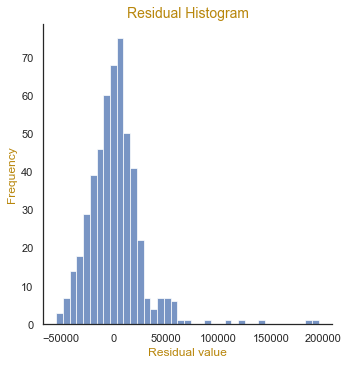

In [17]:
resid_hgram(ytest, yhat)

In [18]:
# ran linear regression again on statsmodel for its summary statistics page
X2 = sm.add_constant(X)
lr_base_sm = sm.OLS(y, X2)
res = lr_base_sm.fit()

In [19]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     634.7
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:35:48   Log-Likelihood:                 1251.7
No. Observations:                2043   AIC:                            -2445.
Df Residuals:                    2014   BIC:                            -2282.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.8198      0.121     56.277      0.000       6.582       7.057
lotarea             0.0934      0.010      9.288      0.000       0.074       0.113
neighborhood        0.0058      0.004      1.403      0.161      -0.002       0.014
overallqual         0.0761      0.004     19.631      0.000       0.069       0.084
overallcond         0.0370      0.003     11.832      0.000       0.031       0.043
totalbsmtsf         0.0012      0.003      0.359      0.720      -0.005       0.008
grlivarea           0.4082      0.017     24.442      0.000       0.375       0.441
kitchenqual         0.0465      0.007      6.824      0.000       0.033       0.060
paveddrive          0.0880      0.012      7.330      0.000       0.064       0.111
zone_FV             0.1938      0.028      6.992      0.000       0.139       0.248
zone_RL             0.1360      0.024      5.750      0.000       0.090       0.182
zone_RM             0.0816      0.024      3.369      0.001       0.034       0.129
lotshape_irr        0.0046      0.007      0.683      0.495      -0.009       0.018
near_busy_st       -0.0393      0.011     -3.624      0.000      -0.060      -0.018
non_1fam           -0.0071      0.012     -0.596      0.551      -0.031       0.016
2plus_fl           -0.0640      0.008     -7.815      0.000      -0.080      -0.048
hip_roof            0.0373      0.008      4.703      0.000       0.022       0.053
ext_ord             0.0068      0.004      1.685      0.092      -0.001       0.015
has_veneer          0.0132      0.007      1.870      0.062      -0.001       0.027
cncrt_found         0.0521      0.009      5.509      0.000       0.034       0.071
bsmt_ord            0.0639      0.005     12.360      0.000       0.054       0.074
heatingqc_dum       0.0148      0.008      1.933      0.053      -0.000       0.030
cent_air_dum        0.0708      0.014      5.178      0.000       0.044       0.098
garage_ord          0.0540      0.009      5.973      0.000       0.036       0.072
fireplace_ord       0.0351      0.006      5.701      0.000       0.023       0.047
lotfrontage_imp     0.0002      0.000      0.841      0.401      -0.000       0.001
remodel_age        -0.0007      0.000     -2.952      0.003      -0.001      -0.000
tot_bath            0.0355      0.006      5.879      0.000       0.024       0.047
deckporcharea       0.0006      0.002      0.367      0.714      -0.002       0.004
==============================================================================
Omnibus:                      965.463   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21759.541
Skew:                          -1.704   Prob(JB):                         0.00
Kurtosis:                      18.621   Cond. No.                     3.32e+03


## Preliminary conclusion for the simple multiple linear regression model (no cross-validation, no regularization)
####         Good news:
- the model is highly accurate with r2 close to 0.9 and RMSE of only 8k away the top of the kaggle leaderboard (26k vs 18k for the winner, altough not tested on holdout data)
- train and test r2 is very similar
- vast majority of coefficients have low p-values, and are thus significant
- the results are especially good considering this is the very first model that was run (aside from the baseline one). it suggest that data cleaning, transformation and column was done quite well.

#### Bad news:
- regularization (lasso and ridge) are unlikely to improve results as variance is not the problem for this model - train and test r2 are similar. 
- another reason why regularization likely won't prove to be useful is that we already cut down the number of columns severely before the regularization will be employed
- neighborhood should be **the** most important variable when pricing real-estate, yet in this model it is statistically insignificant. try to transform it from ordinal into a dummy later. 
- while not as significant as neighborhood, deck/porch area and basement area should be significant. undo the log transformation to see if that improves significance
- as Lasso, Ridge and kfolds cross-validation are unlikely to improve the model by much (if at all), cycle back to feature selection to try to improve the model


<a id = '2.1'><a/>
### 2.1 Lin reg - dummify neighborhoods
* [Back to top](#Content)

In [20]:
ames.shape

(2043, 29)

In [21]:
#get neighborhood dummies to try to improve the significance of what ought to be an important column
ames=pd.get_dummies(ames, columns=['neighborhood'], prefix='nhood')
ames2=pd.get_dummies(ames2, columns=['neighborhood'], prefix='nhood')

In [22]:
# drop one dummy - the middle neighborhood with not much price effect
ames.drop('nhood_2', axis=1, inplace=True)
ames2.drop('nhood_2', axis=1, inplace=True)

In [23]:
#train, test, split
X = ames.drop('saleprice', axis=1)
y = ames['saleprice']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)

lr_base = LinearRegression().fit(Xtrain, ytrain)
yhat = lr_base.predict(Xtest)

print('r2 from train data', round(lr_base.score(Xtrain, ytrain), 3))
print('r2 from test data', round(lr_base.score(Xtest, ytest), 3))

r2 from train data 0.898
r2 from test data 0.895


In [24]:
# get rmse. to make it meaningful and interpretable, the dependent variable should revert to its original form
round(mean_squared_error(np.exp(ytest), np.exp(yhat), squared=False))

26061

In [25]:
X2 = sm.add_constant(X)
lr_base_sm = sm.OLS(y, X2)
res = lr_base_sm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     614.3
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:35:49   Log-Likelihood:                 1254.4
No. Observations:                2043   AIC:                            -2449.
Df Residuals:                    2013   BIC:                            -2280.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.8457      0.121     56.396      0.000       6.608       7.084
lotarea             0.0917      0.010      9.111      0.000       0.072       0.111
overallqual         0.0759      0.004     19.583      0.000       0.068       0.083
overallcond         0.0375      0.003     11.970      0.000       0.031       0.044
totalbsmtsf         0.0018      0.003      0.538      0.591      -0.005       0.008
grlivarea           0.4072      0.017     24.402      0.000       0.375       0.440
kitchenqual         0.0447      0.007      6.532      0.000       0.031       0.058
paveddrive          0.0867      0.012      7.229      0.000       0.063       0.110
zone_FV             0.1794      0.028      6.320      0.000       0.124       0.235
zone_RL             0.1265      0.024      5.276      0.000       0.079       0.174
zone_RM             0.0728      0.024      2.974      0.003       0.025       0.121
lotshape_irr        0.0060      0.007      0.882      0.378      -0.007       0.019
near_busy_st       -0.0411      0.011     -3.785      0.000      -0.062      -0.020
non_1fam           -0.0081      0.012     -0.679      0.497      -0.032       0.015
2plus_fl           -0.0628      0.008     -7.654      0.000      -0.079      -0.047
hip_roof            0.0367      0.008      4.625      0.000       0.021       0.052
ext_ord             0.0067      0.004      1.678      0.094      -0.001       0.015
has_veneer          0.0127      0.007      1.800      0.072      -0.001       0.026
cncrt_found         0.0522      0.009      5.529      0.000       0.034       0.071
bsmt_ord            0.0625      0.005     12.025      0.000       0.052       0.073
heatingqc_dum       0.0136      0.008      1.770      0.077      -0.001       0.029
cent_air_dum        0.0702      0.014      5.142      0.000       0.043       0.097
garage_ord          0.0561      0.009      6.181      0.000       0.038       0.074
fireplace_ord       0.0376      0.006      6.018      0.000       0.025       0.050
lotfrontage_imp     0.0002      0.000      0.817      0.414      -0.000       0.001
remodel_age        -0.0007      0.000     -3.045      0.002      -0.001      -0.000
tot_bath            0.0365      0.006      6.040      0.000       0.025       0.048
deckporcharea       0.0004      0.002      0.276      0.783      -0.003       0.003
nhood_1             0.0117      0.009      1.357      0.175      -0.005       0.029
nhood_3             0.0257      0.010      2.682      0.007       0.007       0.045
==============================================================================
Omnibus:                      974.677   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22327.349
Skew:                          -1.722   Prob(JB):                         

#### 1) After dummifying the neighborhood feature, r2 and rmse improved just a very bit, but p-values of neighboorhood dummies are 0.175 and 0.007, which, on average, is much better than former neighborhood p-value of 0.161. keep as dummies.

#### 2) Next, try to make basement and deck/porch area features more significant by undoing their log transformation. This actually makes sense from the business perspective, as only major area columns like lotsize and livingarea ought to be transformed along with the saleprice to keep the common real-estate metric of "price per square foot" intact. Smaller area features such as basement and deck area are not part of that metric (ie real-estate is never priced in terms of 'price per square foot of the basement') so those shouldn't have been log transformed in the first place) 

In [26]:
ames.shape

(2043, 30)

<a id = '2.2'><a/>
### 2.2 Lin reg - undo deck/bsmt transformations
* [Back to top](#Content)

In [27]:
# undo log transformation of deckporch and basement area columns
ames['deckporcharea'] = np.exp(ames['deckporcharea'])-1
ames['totalbsmtsf'] = np.exp(ames['totalbsmtsf'])-1

ames2['deckporcharea'] = np.exp(ames2['deckporcharea'])-1
ames2['totalbsmtsf'] = np.exp(ames2['totalbsmtsf'])-1

In [28]:
#train, test, split
X = ames.drop('saleprice', axis=1)
y = ames['saleprice']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)
lr_base = LinearRegression().fit(Xtrain, ytrain)
yhat = lr_base.predict(Xtest)

print('r2 from train data', round(lr_base.score(Xtrain, ytrain), 3))
print('r2 from test data', round(lr_base.score(Xtest, ytest), 3))

r2 from train data 0.904
r2 from test data 0.898


In [29]:
# get rmse. to make it meaningful and interpretable, the dependent variable should revert
# to its original form
round(mean_squared_error(np.exp(ytest), np.exp(yhat), squared=False))

25154

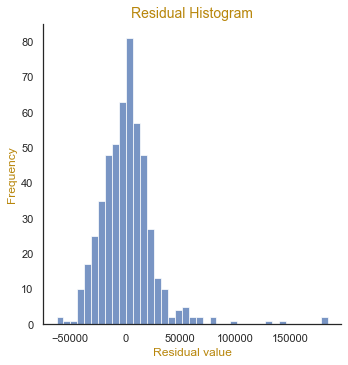

In [30]:
resid_hgram(ytest, yhat)

- the residuals look much more normally distributed than before

In [31]:
X2 = sm.add_constant(X)
lr_base_sm = sm.OLS(y, X2)
res = lr_base_sm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     648.5
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:35:49   Log-Likelihood:                 1304.3
No. Observations:                2043   AIC:                            -2549.
Df Residuals:                    2013   BIC:                            -2380.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.2907      0.127     57.574      0.000       7.042       7.539
lotarea             0.0862      0.010      8.758      0.000       0.067       0.106
overallqual         0.0689      0.004     18.002      0.000       0.061       0.076
overallcond         0.0403      0.003     13.081      0.000       0.034       0.046
totalbsmtsf         0.0001   1.11e-05      9.895      0.000    8.84e-05       0.000
grlivarea           0.3468      0.017     20.187      0.000       0.313       0.381
kitchenqual         0.0426      0.007      6.381      0.000       0.029       0.056
paveddrive          0.0861      0.012      7.366      0.000       0.063       0.109
zone_FV             0.1835      0.028      6.630      0.000       0.129       0.238
zone_RL             0.1288      0.023      5.503      0.000       0.083       0.175
zone_RM             0.0803      0.024      3.359      0.001       0.033       0.127
lotshape_irr        0.0076      0.007      1.154      0.249      -0.005       0.021
near_busy_st       -0.0396      0.011     -3.740      0.000      -0.060      -0.019
non_1fam           -0.0099      0.011     -0.866      0.387      -0.032       0.013
2plus_fl           -0.0168      0.009     -1.805      0.071      -0.035       0.001
hip_roof            0.0251      0.008      3.213      0.001       0.010       0.040
ext_ord             0.0059      0.004      1.501      0.133      -0.002       0.014
has_veneer          0.0095      0.007      1.384      0.167      -0.004       0.023
cncrt_found         0.0486      0.009      5.277      0.000       0.031       0.067
bsmt_ord            0.0484      0.005     10.302      0.000       0.039       0.058
heatingqc_dum       0.0142      0.007      1.891      0.059      -0.001       0.029
cent_air_dum        0.0664      0.013      4.998      0.000       0.040       0.092
garage_ord          0.0586      0.009      6.647      0.000       0.041       0.076
fireplace_ord       0.0373      0.006      6.110      0.000       0.025       0.049
lotfrontage_imp     0.0001      0.000      0.598      0.550      -0.000       0.000
remodel_age        -0.0007      0.000     -3.086      0.002      -0.001      -0.000
tot_bath            0.0355      0.006      6.035      0.000       0.024       0.047
deckporcharea    3.507e-05   2.25e-05      1.561      0.119   -8.98e-06    7.91e-05
nhood_1             0.0057      0.008      0.674      0.500      -0.011       0.022
nhood_3             0.0233      0.009      2.503      0.012       0.005       0.042
==============================================================================
Omnibus:                     1045.475   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29478.143
Skew:                          -1.835   Prob(JB):                         

#### A huge improvement! p-values went down from 0.59 and 0.78 to 0.00 and 0.12! RMSE and R2 also improved. The results speak for themselves - keep the changes.

<a id = '3.0'><a/>
### 3.0 K-folds cross-validation
* [Back to top](#Content)

In [32]:
# run cross-validation with different number of folds - from 4 to 8
for folds in range(4,9):
    print ('------------------------------------\n')
    print ('K:', folds)
    model = LinearRegression()
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=folds)
    rounded_scores = [round(i, 4) for i in scores]
    print ("Cross-validated scores:", rounded_scores)
    print ("Mean CV R2:", round(np.mean(scores), 4))
    print ('Std CV R2:', round(np.std(scores), 4))
    
    # Make cross-validated predictions
    predictions = cross_val_predict(model, X, y, cv=folds)
    
    r2 = r2_score(y, predictions)
    rmse = mean_squared_error(np.exp(y), np.exp(predictions), squared=False)
    print("Cross-predicted R2:", round(r2, 4))
    print("Cross-predicted RMSE:", round(rmse))

------------------------------------

K: 4
Cross-validated scores: [0.8779, 0.9094, 0.9121, 0.8921]
Mean CV R2: 0.8979
Std CV R2: 0.0139
Cross-predicted R2: 0.8976
Cross-predicted RMSE: 23451
------------------------------------

K: 5
Cross-validated scores: [0.8801, 0.9008, 0.9113, 0.8832, 0.9155]
Mean CV R2: 0.8982
Std CV R2: 0.0143
Cross-predicted R2: 0.8975
Cross-predicted RMSE: 23384
------------------------------------

K: 6
Cross-validated scores: [0.8876, 0.8887, 0.9053, 0.9156, 0.8832, 0.9123]
Mean CV R2: 0.8988
Std CV R2: 0.0128
Cross-predicted R2: 0.8981
Cross-predicted RMSE: 23404
------------------------------------

K: 7
Cross-validated scores: [0.8786, 0.8843, 0.913, 0.9162, 0.915, 0.8755, 0.9095]
Mean CV R2: 0.8989
Std CV R2: 0.0171
Cross-predicted R2: 0.8982
Cross-predicted RMSE: 23395
------------------------------------

K: 8
Cross-validated scores: [0.8712, 0.8832, 0.9172, 0.9098, 0.9175, 0.9074, 0.8754, 0.9133]
Mean CV R2: 0.8994
Std CV R2: 0.0182
Cross-predicted R

#### The results are quite consisent - mean cross-validation r2 range from 0.897 to 0.899 and therefore the model is reliable. Cross-predicted rmse is not reliable since cross_value_predict is a result of multiple different models, so the fact that is much lower than previous rmse's does not hold weight.

<a id = '4.0'><a/>
### 4.0 Ridge regression
* [Back to top](#Content)

In [33]:
# standardize before regularizing not to penalize large coefficients. 
# fit on X train only, so that transformation is uniform
sc = StandardScaler()
Xtrain_sc = sc.fit_transform(Xtrain)
Xtest_sc = sc.transform(Xtest)

In [34]:
# create a list of alphas on different scales, using np.log
rd_alpha = np.logspace(-5, 5, 800)

#find the best alpha for the model
rd_cv = RidgeCV(rd_alpha, cv = 5, scoring = 'r2')

# Fit model using best ridge alpha!
rd_cv.fit(Xtrain_sc, ytrain)
best_alpha = rd_cv.alpha_
print('ideal alpha is ', round(best_alpha, 2))

ideal alpha is  51.1


In [35]:
ridge_m = Ridge(alpha=best_alpha).fit(Xtrain_sc, ytrain)

In [36]:
# making sure the two sets of of two scores are identical, in which case all was done correctly
print(f'Train Score:  {ridge_m.score(Xtrain_sc, ytrain):.4f} ')
print(f'Test Score:  {ridge_m.score(Xtest_sc, ytest):.4f} \n')

print(f'Train Score:  {rd_cv.score(Xtrain_sc, ytrain):.4f}')
print(f'Test Score:  {rd_cv.score(Xtest_sc, ytest):.4f}')

Train Score:  0.9031 
Test Score:  0.8997 

Train Score:  0.9031
Test Score:  0.8997


In [37]:
print('ridge r2 is ', round(rd_cv.score(Xtest_sc, ytest),4))

#get prediction for ridge
yhat = rd_cv.predict(Xtest_sc)

print('ridge r2 after reversing the log transformation is ', round(r2_score(np.exp(ytest),
                                                                            np.exp(yhat)),4))
print('ridge rmse is ', round(mean_squared_error(np.exp(ytest), np.exp(yhat), squared=False)))

ridge r2 is  0.8997
ridge r2 after reversing the log transformation is  0.9029
ridge rmse is  25119


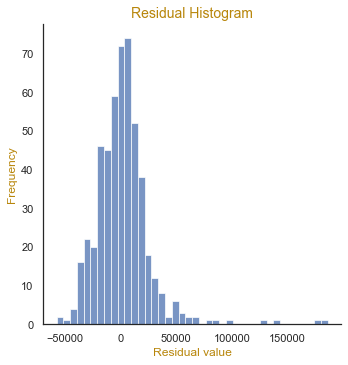

In [38]:
resid_hgram(ytest, yhat)

In [39]:
Coef_r = zip(X.columns, rd_cv.coef_)

In [40]:
list(Coef_r)

[('lotarea', 0.036958535328132466),
 ('overallqual', 0.09487471685669363),
 ('overallcond', 0.043479756312415255),
 ('totalbsmtsf', 0.052258389434899466),
 ('grlivarea', 0.10987164595601627),
 ('kitchenqual', 0.03046318815275271),
 ('paveddrive', 0.02963742015019551),
 ('zone_FV', 0.027806170521414233),
 ('zone_RL', 0.03111019361043922),
 ('zone_RM', 0.010827595411515135),
 ('lotshape_irr', 0.005026264515399005),
 ('near_busy_st', -0.006195315286669879),
 ('non_1fam', -0.0020917972766281204),
 ('2plus_fl', -0.0028397217318632973),
 ('hip_roof', 0.013434492173308577),
 ('ext_ord', 0.00414249099019145),
 ('has_veneer', 0.0029229478566153416),
 ('cncrt_found', 0.024248235102362774),
 ('bsmt_ord', 0.042257681676302006),
 ('heatingqc_dum', 0.008895262225639647),
 ('cent_air_dum', 0.017077425473838576),
 ('garage_ord', 0.023825596911319906),
 ('fireplace_ord', 0.02146398654018064),
 ('lotfrontage_imp', 0.005674435247172222),
 ('remodel_age', -0.01725907713722907),
 ('tot_bath', 0.02588181985

<a id = '5.0'><a/>
### 5.0 Lasso regression
* [Back to top](#Content)

In [41]:
# use n_asphas for LassoCV to create alphas rather than logspace

lasso_cv = LassoCV(n_alphas = 800, cv=5)

lasso_cv.fit(Xtrain_sc, ytrain)

best_alpha2 = lasso_cv.alpha_
print ('ideal alpha is ', round(lasso_cv.alpha_,4))

ideal alpha is  0.0021


In [42]:
print('lasso r2 is ', round(lasso_cv.score(Xtest_sc, ytest),4))

#get prediction for lasso
yhat = lasso_cv.predict(Xtest_sc)

print('lasso r2 after reversing the log transformation is ', round(r2_score(np.exp(ytest),
                                                                            np.exp(yhat)),4))
print('lasso rmse is ', round(mean_squared_error(np.exp(ytest), np.exp(yhat), squared=False)))

lasso r2 is  0.8972
lasso r2 after reversing the log transformation is  0.9017
lasso rmse is  25266


In [43]:
Coef_l = zip(X.columns, lasso_cv.coef_)

In [44]:
list(Coef_l)

[('lotarea', 0.03891318671150378),
 ('overallqual', 0.1021408167730694),
 ('overallcond', 0.04139568180770648),
 ('totalbsmtsf', 0.05288435859645084),
 ('grlivarea', 0.11334506309405776),
 ('kitchenqual', 0.029931776998465442),
 ('paveddrive', 0.02979962645943907),
 ('zone_FV', 0.020184300617497583),
 ('zone_RL', 0.01960972947673235),
 ('zone_RM', -0.0),
 ('lotshape_irr', 0.0028603881920846288),
 ('near_busy_st', -0.004668714093466732),
 ('non_1fam', -0.000637795574173119),
 ('2plus_fl', -0.0009720675168370709),
 ('hip_roof', 0.011693418361423619),
 ('ext_ord', 0.0015937952906055605),
 ('has_veneer', 0.0005621981929374241),
 ('cncrt_found', 0.022894369462109706),
 ('bsmt_ord', 0.04472960220955982),
 ('heatingqc_dum', 0.008464674116877263),
 ('cent_air_dum', 0.016954038392364035),
 ('garage_ord', 0.02340608222386276),
 ('fireplace_ord', 0.018618898309149593),
 ('lotfrontage_imp', 0.0026920063205681313),
 ('remodel_age', -0.01703857275426596),
 ('tot_bath', 0.022251286592566828),
 ('deck

In [45]:
print(" OLS ".center(18, "="))
print(lr_base.score(Xtrain, ytrain))
print(lr_base.score(Xtest, ytest), '\n')
print(" Ridge ".center(18, "="))
print(rd_cv.score(Xtrain_sc, ytrain))
print(rd_cv.score(Xtest_sc, ytest), '\n')
print(" Lasso ".center(18, "="))
print(lasso_cv.score(Xtrain_sc, ytrain))
print(lasso_cv.score(Xtest_sc, ytest))

====== OLS =======
0.9036392752570962
0.8984750357094147 

===== Ridge ======
0.9031219245536836
0.899740183065329 

===== Lasso ======
0.9027014892947234
0.8971771460902449


- as we predicted, Ridge and Lasso didn't improve the score by much, if it all. The OLS model had a high r2 score on both train and test data, so there was not much that Ridge and Lasso could do. The number of columns was already reduced before the regularization kicked in. Had we not reduced the number of columns severely during EDA, regularization benefits would've been much more keenly felt
- next: try to improve results through feature selection

<a id = '6.0'><a/>
### 6.0 Wrapper method search
* [Back to top](#Content)

- in a nutshell, our LinReg already has good predictive power. Due to that, not much improvement was noticed after regularization (as we expected). 
- the biggest reason for that was that we cut down the number of columns to only the essential ones (from 80 to 28), in addition to transforming them to give as much predictive power as possible. In such a system, there is not much need for regularization, which is more useful when it's needed to that job of reducing the number of columns
- therefore the only thing that remains to be done is adjusting features to arrive at the winning combo.

<a id = '6.1'><a/>
### 6.1 Drop 9 features
* [Back to top](#Content)

- first try a bit of brute force in order to stumble upon 20-feature list that produces similar r2 and rmse but with (9) fewer features (20 vs 29). call the function optimal_features created above. that function is especially customised for 20-features list: since there are over 10 million combinations, only 50 thousand will be tested due to computing capacity and speed

In [46]:
len(list(itertools.combinations(X.columns, 20)))

10015005

In [47]:
# run the function to select 20 out of 29 features that give best r2 
# as there are more than 10m combination, the function will select a random sample of 50000
# to keep the running time of the cell under 10 minutes
top20 = optimal_features(20)

best r2 is:  0.9002 

best 20-feature group is:  ['lotarea', 'overallqual', 'overallcond', 'totalbsmtsf', 'grlivarea', 'kitchenqual', 'zone_FV', 'zone_RL', 'near_busy_st', '2plus_fl', 'cncrt_found', 'bsmt_ord', 'cent_air_dum', 'garage_ord', 'fireplace_ord', 'lotfrontage_imp', 'remodel_age', 'tot_bath', 'nhood_1', 'nhood_3']


'discarded features are: '

{'deckporcharea',
 'ext_ord',
 'has_veneer',
 'heatingqc_dum',
 'hip_roof',
 'lotshape_irr',
 'non_1fam',
 'paveddrive',
 'zone_RM'}

- the cell above took a long time to run. the kernel got reset after that, but the 'winning' list of features is printed, copied and pasted below
- the proof that the function optimal_features indeed works is below when we use it to drop only 2-4 features, which doesn't take nearly as long and does not require random sampling

In [48]:
top20

['lotarea',
 'overallqual',
 'overallcond',
 'totalbsmtsf',
 'grlivarea',
 'kitchenqual',
 'zone_FV',
 'zone_RL',
 'near_busy_st',
 '2plus_fl',
 'cncrt_found',
 'bsmt_ord',
 'cent_air_dum',
 'garage_ord',
 'fireplace_ord',
 'lotfrontage_imp',
 'remodel_age',
 'tot_bath',
 'nhood_1',
 'nhood_3']

In [49]:
# copy and paste to hardcode the winning list of features with only
top20_hc = ['lotarea', 'overallqual','overallcond','totalbsmtsf','grlivarea','kitchenqual',
 'zone_FV','zone_RL','near_busy_st','non_1fam','2plus_fl','ext_ord','bsmt_ord','cent_air_dum',
 'garage_ord','fireplace_ord','lotfrontage_imp','remodel_age','tot_bath','nhood_3']

In [50]:
# list of 9 columns that were discarded
set(X.columns) - set(top20_hc)
# discarded: {'cncrt_found','deckporcharea','has_veneer','heatingqc_dum','hip_roof','lotshape_irr','nhood_1',
#  'paveddrive','zone_RM'}

{'cncrt_found',
 'deckporcharea',
 'has_veneer',
 'heatingqc_dum',
 'hip_roof',
 'lotshape_irr',
 'nhood_1',
 'paveddrive',
 'zone_RM'}

#### now we don't have to run the function to find the top20 columns  for 10 minutes everytime we restart - the result is hardcoded into top20_hc

<a id = '6.2'><a/>
### 6.2 Ridge and Lasso without 9 features
* [Back to top](#Content)

In [51]:
# standardize before regularizing not to penalize large coefficients. 
# fit on Xtrain only, so that transformation is uniform
sc = StandardScaler()
Xtrain_sc = sc.fit_transform(Xtrain[top20_hc])
Xtest_sc = sc.transform(Xtest[top20_hc])

In [52]:
# Ridge regression with 20 features
# create a list of alphas on different scales, using np.log
rd_alpha = np.logspace(-5, 5, 800)

#find the best alpha for the model
rd_cv = RidgeCV(rd_alpha, cv = 5, scoring = 'r2')

# Fit model using best ridge alpha!
rd_cv.fit(Xtrain_sc, ytrain)
best_alpha = rd_cv.alpha_
print('ideal alpha is ', round(best_alpha, 2))

ideal alpha is  32.22


In [53]:
print('ridge r2 is ', round(rd_cv.score(Xtest_sc, ytest),4))

#get prediction for ridge
yhat = rd_cv.predict(Xtest_sc)

print('ridge r2 after reversing the log transformation is ', round(r2_score(np.exp(ytest),
                                                                            np.exp(yhat)),4))
print('ridge rmse is ', round(mean_squared_error(np.exp(ytest), np.exp(yhat), squared=False)))

ridge r2 is  0.9008
ridge r2 after reversing the log transformation is  0.9044
ridge rmse is  24926


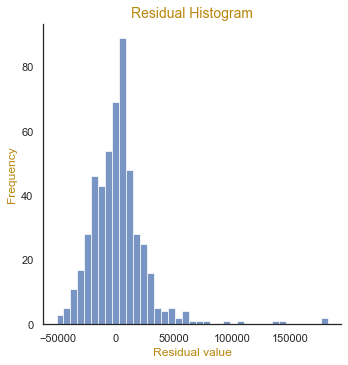

In [54]:
#check the residual histogram
resid_hgram(ytest, yhat)

#### this is an improvement over the prior Ridge regression: the stats in the cell above (0.9008, 0.9044, 24926) are better than the numbers from the prior Ridge regression with a full set of 29 features (0.8997, 0.9029, 25119). The improvement in stats is miniscule, but the real improvement is getting it while reducing the number of features by 1/3.

In [55]:
# Lasso regression with 20 features
# use n_asphas for LassoCV to create alphas rather than logspace

lasso_cv = LassoCV(n_alphas = 800, cv=5)

lasso_cv.fit(Xtrain_sc, ytrain)

best_alpha2 = lasso_cv.alpha_
print ('ideal alpha is ', round(lasso_cv.alpha_,4))

ideal alpha is  0.0003


In [56]:
print('lasso r2 is ', round(lasso_cv.score(Xtest_sc, ytest),4))

#get prediction for lasso
yhat = lasso_cv.predict(Xtest_sc)

print('lasso r2 after reversing the log transformation is ', round(r2_score(np.exp(ytest),
                                                                            np.exp(yhat)),4))
print('lasso rmse is ', round(mean_squared_error(np.exp(ytest), np.exp(yhat), squared=False)))

lasso r2 is  0.9
lasso r2 after reversing the log transformation is  0.9043
lasso rmse is  24931


#### this is an improvement over the prior Lasso regression: the stats in the cell above (0.9000, 0.9043, 24931) are better than the numbers from the prior Ridge regression which had a full set of 29 features (0.8972, 0.9017, 25266). The improvement in stats is miniscule, but the real improvement is getting it while reducing the number of features by 1/3.

#### next up: instead of dropping 9 features, lets just drop 2, 3 and 4. this is much faster as the number of combinations is hundreds of times smaller.

<a id = '6.3'><a/>
### 6.3 Drop 2, 3 and 4 features
* [Back to top](#Content)

#### unlike droping 9 columns, dropping 2, 3 or 4 doesn't take much processing time

In [57]:
top27 = optimal_features(27)

best r2 is:  0.9008 

best 27-feature group is:  ['lotarea', 'overallqual', 'overallcond', 'totalbsmtsf', 'grlivarea', 'kitchenqual', 'zone_FV', 'zone_RL', 'zone_RM', 'lotshape_irr', 'near_busy_st', 'non_1fam', '2plus_fl', 'ext_ord', 'has_veneer', 'cncrt_found', 'bsmt_ord', 'heatingqc_dum', 'cent_air_dum', 'garage_ord', 'fireplace_ord', 'lotfrontage_imp', 'remodel_age', 'tot_bath', 'deckporcharea', 'nhood_1', 'nhood_3']


'discarded features are: '

{'hip_roof', 'paveddrive'}

In [58]:
#the above cell shows that the best combo with 27 features is with {'hip_roof', 'paveddrive'}
# discarded
optimal_features(26)

best r2 is:  0.9013 

best 26-feature group is:  ['lotarea', 'overallqual', 'overallcond', 'totalbsmtsf', 'grlivarea', 'kitchenqual', 'zone_FV', 'zone_RL', 'zone_RM', 'lotshape_irr', 'near_busy_st', 'non_1fam', '2plus_fl', 'ext_ord', 'has_veneer', 'cncrt_found', 'bsmt_ord', 'heatingqc_dum', 'cent_air_dum', 'garage_ord', 'fireplace_ord', 'lotfrontage_imp', 'remodel_age', 'tot_bath', 'nhood_1', 'nhood_3']


'discarded features are: '

{'deckporcharea', 'hip_roof', 'paveddrive'}

['lotarea',
 'overallqual',
 'overallcond',
 'totalbsmtsf',
 'grlivarea',
 'kitchenqual',
 'zone_FV',
 'zone_RL',
 'zone_RM',
 'lotshape_irr',
 'near_busy_st',
 'non_1fam',
 '2plus_fl',
 'ext_ord',
 'has_veneer',
 'cncrt_found',
 'bsmt_ord',
 'heatingqc_dum',
 'cent_air_dum',
 'garage_ord',
 'fireplace_ord',
 'lotfrontage_imp',
 'remodel_age',
 'tot_bath',
 'nhood_1',
 'nhood_3']

In [59]:
#the above cell shows that the best combo with 26 features is with {'hip_roof', 'paveddrive',
# and deckporcharea} discarded
optimal_features(25)

best r2 is:  0.9015 

best 25-feature group is:  ['lotarea', 'overallqual', 'overallcond', 'totalbsmtsf', 'grlivarea', 'kitchenqual', 'zone_FV', 'zone_RL', 'zone_RM', 'lotshape_irr', 'near_busy_st', 'non_1fam', '2plus_fl', 'ext_ord', 'has_veneer', 'cncrt_found', 'bsmt_ord', 'cent_air_dum', 'garage_ord', 'fireplace_ord', 'lotfrontage_imp', 'remodel_age', 'tot_bath', 'nhood_1', 'nhood_3']


'discarded features are: '

{'deckporcharea', 'heatingqc_dum', 'hip_roof', 'paveddrive'}

['lotarea',
 'overallqual',
 'overallcond',
 'totalbsmtsf',
 'grlivarea',
 'kitchenqual',
 'zone_FV',
 'zone_RL',
 'zone_RM',
 'lotshape_irr',
 'near_busy_st',
 'non_1fam',
 '2plus_fl',
 'ext_ord',
 'has_veneer',
 'cncrt_found',
 'bsmt_ord',
 'cent_air_dum',
 'garage_ord',
 'fireplace_ord',
 'lotfrontage_imp',
 'remodel_age',
 'tot_bath',
 'nhood_1',
 'nhood_3']

- finally, with 4 columns to discard, the 4 that give the highest r2 are {'deckporcharea', 'heatingqc_dum', 'hip_roof', 'paveddrive'}
- the same colums appear as candidates for the discard, whether we are discarding 2,3,4 or 9 columns
- later when we add 3 new 'year sold' dummies, we will discard the top names on discard lists, which are {'deckporcharea', 'hip_roof' and 'paveddrive'} as our goal is never to go beyond 30 features

In [60]:
# run LinReg on the 25 features set, as it produced the highest r2. 
# after we run we should get the same r2 of 0.9015, and we'll also get to see the rmse.
Xtrain3 = Xtrain.drop(columns=['deckporcharea', 'heatingqc_dum', 'hip_roof', 'paveddrive'])
Xtest3 = Xtest.drop(columns=['deckporcharea', 'heatingqc_dum', 'hip_roof', 'paveddrive'])

lr2 = LinearRegression().fit(Xtrain3, ytrain)
print('r2 is', round(lr2.score(Xtest3, ytest), 4))
yhat = lr2.predict(Xtest3)
print('rmse is', round(mean_squared_error(np.exp(ytest), np.exp(yhat), squared=False)))
print('r2 after reversing the log transformation is', round(r2_score(np.exp(ytest), np.exp(yhat)), 4))

r2 is 0.9015
rmse is 24959
r2 after reversing the log transformation is 0.9041


In [61]:
cross_val_score(lr2, Xtrain3, ytrain, cv=8).mean()

0.8924583816211435

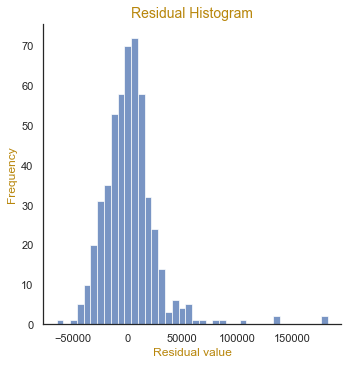

In [62]:
# check the residual histogram
resid_hgram(ytest, yhat)

#### this 'brute force' project was somewhat successful. it took a lot of time and computational resources, but we managed to improve the r2 and rmse somewhat. we also got rid of a few columns, which we can now replace with 'yr sold' and still be under our goal of 30.

<a id = '6.4'><a/>
### 6.4 Add back the 'year sold' column
* [Back to top](#Content)

In [63]:
Xtrain.head()

,lotarea,overallqual,overallcond,totalbsmtsf,grlivarea,kitchenqual,paveddrive,zone_FV,zone_RL,zone_RM,...,heatingqc_dum,cent_air_dum,garage_ord,fireplace_ord,lotfrontage_imp,remodel_age,tot_bath,deckporcharea,nhood_1,nhood_3
1854,8.909776,4,6,861.0,6.758095,1,0,0,0,1,...,0,1,1.00,0.00,62.000000,61,1.0,0.0,1,0
250,9.386728,8,7,1242.0,7.824446,2,1,0,1,0,...,1,1,2.00,1.00,76.978789,16,2.5,279.0,0,1
413,9.200290,6,7,778.0,7.305860,1,1,0,1,0,...,0,1,0.67,1.25,60.000000,61,2.0,335.0,1,0
1333,9.069353,7,5,1425.0,7.261927,1,1,0,1,0,...,1,1,1.67,0.00,65.804133,13,3.0,130.0,1,0
310,9.606428,8,5,1778.0,7.487734,2,1,0,1,0,...,1,1,2.00,1.25,85.821139,8,3.0,217.0,1,0


In [64]:
Xtest.head()

,lotarea,overallqual,overallcond,totalbsmtsf,grlivarea,kitchenqual,paveddrive,zone_FV,zone_RL,zone_RM,...,heatingqc_dum,cent_air_dum,garage_ord,fireplace_ord,lotfrontage_imp,remodel_age,tot_bath,deckporcharea,nhood_1,nhood_3
1316,9.168268,8,5,1482.0,7.853216,3,1,0,1,0,...,1,1,2.33,1.25,69.000000,4,2.5,148.0,1,0
1000,9.166597,8,5,1453.0,7.940940,2,1,0,1,0,...,1,1,1.67,1.75,69.041669,21,2.5,500.0,0,1
1068,8.384576,8,5,1378.0,7.228388,2,1,1,0,0,...,1,1,1.67,1.25,45.000000,7,3.0,216.0,0,1
1970,9.342596,7,8,728.0,7.610358,2,1,0,1,0,...,0,0,1.00,0.00,60.000000,18,1.0,644.0,1,0
529,9.298901,5,5,1678.0,7.425358,1,1,0,1,0,...,0,1,0.00,0.00,65.000000,52,2.0,0.0,0,1


#### merge the 'year sold' column into test and train set

In [65]:
#add it to both train and test dataframe, use left join on index
Xtrain = pd.merge(Xtrain, yr, how='left', right_index=True, left_index=True)
Xtest = pd.merge(Xtest, yr, how='left', right_index=True, left_index=True)

In [66]:
# if some index numbers didn't line up, there'd be null values
Xtrain.isnull().sum().sum()

0

In [67]:
print(Xtrain.shape, Xtest.shape)

(1532, 30) (511, 30)


In [68]:
# it looks ok, but still check 2 rows from both test and train to make sure the merge was ok
df_check = pd.read_csv('../datasets/train_cat&num_clean.csv')

In [69]:
df_check.loc[[1970,529]]

,lotarea,neighborhood,overallqual,overallcond,totalbsmtsf,grlivarea,kitchenqual,paveddrive,yrsold,saleprice,...,cncrt_found,bsmt_ord,heatingqc_dum,cent_air_dum,garage_ord,fireplace_ord,lotfrontage_imp,remodel_age,tot_bath,deckporcharea
1970,9.342596,1,7,8,6.591674,7.610358,2,1,2009,12.028739,...,0,2.00,0,0,1.0,0.0,60.0,18,1.0,6.46925
529,9.298901,3,5,5,7.425954,7.425358,1,1,2009,11.694413,...,0,1.75,0,1,0.0,0.0,65.0,52,2.0,0.00000


In [70]:
Xtest.loc[[1970,529]]

,lotarea,overallqual,overallcond,totalbsmtsf,grlivarea,kitchenqual,paveddrive,zone_FV,zone_RL,zone_RM,...,cent_air_dum,garage_ord,fireplace_ord,lotfrontage_imp,remodel_age,tot_bath,deckporcharea,nhood_1,nhood_3,yrsold
1970,9.342596,7,8,728.0,7.610358,2,1,0,1,0,...,0,1.0,0.0,60.0,18,1.0,644.0,1,0,2009
529,9.298901,5,5,1678.0,7.425358,1,1,0,1,0,...,1,0.0,0.0,65.0,52,2.0,0.0,0,1,2009


In [71]:
Xtrain.loc[[1854,250]]

,lotarea,overallqual,overallcond,totalbsmtsf,grlivarea,kitchenqual,paveddrive,zone_FV,zone_RL,zone_RM,...,cent_air_dum,garage_ord,fireplace_ord,lotfrontage_imp,remodel_age,tot_bath,deckporcharea,nhood_1,nhood_3,yrsold
1854,8.909776,4,6,861.0,6.758095,1,0,0,0,1,...,1,1.0,0.0,62.000000,61,1.0,0.0,1,0,2009
250,9.386728,8,7,1242.0,7.824446,2,1,0,1,0,...,1,2.0,1.0,76.978789,16,2.5,279.0,0,1,2008


In [72]:
df_check.iloc[[1854,250]]

,lotarea,neighborhood,overallqual,overallcond,totalbsmtsf,grlivarea,kitchenqual,paveddrive,yrsold,saleprice,...,cncrt_found,bsmt_ord,heatingqc_dum,cent_air_dum,garage_ord,fireplace_ord,lotfrontage_imp,remodel_age,tot_bath,deckporcharea
1854,8.909776,1,4,6,6.759255,6.758095,1,0,2009,11.289782,...,0,1.50,0,1,1.0,0.0,62.000000,61,1.0,0.00000
250,9.386728,3,8,7,7.125283,7.824446,2,1,2008,12.577636,...,1,2.75,1,1,2.0,1.0,76.978789,16,2.5,5.63479


In [73]:
del df_check

- 'yrsold' lines up, so the merge went well
- now dummify the year column


In [74]:
Xtrain2 = pd.get_dummies(Xtrain, columns=['yrsold'], drop_first=True, prefix='yr')
Xtest2 = pd.get_dummies(Xtest, columns=['yrsold'], drop_first=True, prefix='yr')

In [75]:
Xtrain2.drop(columns=['deckporcharea', 'hip_roof', 'paveddrive'], inplace=True)
Xtest2.drop(columns=['deckporcharea', 'hip_roof', 'paveddrive'], inplace=True)

In [76]:
print(Xtrain2.shape, Xtest2.shape)

(1532, 30) (511, 30)


In [77]:
lr1 = LinearRegression().fit(Xtrain2, ytrain)
yhat = lr1.predict(Xtest2)

print('r2 from train data', round(lr1.score(Xtrain2, ytrain), 3))
print('r2 from test data', round(lr1.score(Xtest2, ytest), 3))
print('rmse from test data', round(mean_squared_error(np.exp(ytest), np.exp(yhat),
                                                      squared=False)))

r2 from train data 0.899
r2 from test data 0.902
rmse from test data 25220


#### adding 'year sold' dummies has not proven fruitful. try running Ridge regression with the dummies to see if that helps.

In [78]:
# standardize before regularizing not to penalize large coefficients. 
# fit on Xtrain only, so that transformation is uniform
sc = StandardScaler()
Xtrain_sc2 = sc.fit_transform(Xtrain2)
Xtest_sc2 = sc.transform(Xtest2)

In [79]:
rd_cv1 = RidgeCV(rd_alpha, cv = 5, scoring = 'r2')

# Fit model using best ridge alpha
rd_cv1.fit(Xtrain_sc2, ytrain)

best_alpha = rd_cv1.alpha_
print('ideal alpha is ', round(best_alpha, 2))

ideal alpha is  46.86


In [80]:
rd_cv1.score(Xtest_sc2, ytest)

0.9022875707010274

In [81]:
print('ridge r2 is ', round(rd_cv1.score(Xtest_sc2, ytest),4))

#get prediction for ridge
yhat = rd_cv1.predict(Xtest_sc2)

print('ridge r2 after reversing the log transformation is ', round(r2_score(np.exp(ytest),
                                                                            np.exp(yhat)),4))
print('ridge rmse is ', round(mean_squared_error(np.exp(ytest), np.exp(yhat), squared=False)))

ridge r2 is  0.9023
ridge r2 after reversing the log transformation is  0.9023
ridge rmse is  25195


In [82]:
# the year dummy columns don't add value. take them out
Xtrain.drop('yrsold', axis=1, inplace=True)
Xtest.drop('yrsold', axis=1, inplace=True)

<a id = '6.5'><a/>
## 6.5 Models summary
* [Back to top](#Content)

| No |                                MODEL                               | FTRS | TEST R2 | TEST RMSE |                                                                                                                                                COMMENTS                                                                                                                                               |
|----|:------------------------------------------------------------------:|-----:|--------:|----------:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| 1  |                               LinReg                               |   28 |   0.894 |     26173 |                                                                                                                         nghbhood, deck and bsmt insignificant.<br>shouldn't be                                                                                                                        |
| 2  |                     Same as 1 +<br>dummy nghood                    |   29 |   0.895 |     26601 |                                                                                                                                   nhood dummies are significant now                                                                                                                                   |
| 3  |           Same as 2 +<br>undo deck/bsmt<br>transformation          |   29 |   0.898 |     25154 |                                                                                                                     big improvement in rmse. both bsmt<br>and deck now significant                                                                                                                    |
| 4  |                    Same as 3 +<br>cross-val k=8                    |   29 |   0.899 |    23357* |                                                                         - rmse improvement not to be trusted<br>as cross_val_predict employs multiple<br>models at the same time<br> -cross_val does prove the model is solid                                                                         |
| 5  |                          Same as 3 + Ridge                         |   29 |   0.900 |     25119 |                                                                                                                        - alpha=51, not very high<br>- Ridge reg. didn't do much                                                                                                                       |
| 6  |                          Same as 3 + Lasso                         |   29 |   0.897 |     25266 |                                                                                                                   - alpha=0.021, insignificant<br>-Lasso reg. didn't do much either                                                                                                                   |
| 7  | LinReg with optimal<br>feature selector to <br>cut down 9 features |   20 |   0.900 |           |                                                                                  - not strictly 'optimal' since not all<br>among 10m combinations were tested<br>- amazing result considering 9 features<br>were cut                                                                                  |
| 8  |                          Same as 7 + Ridge                         |   20 |   0.901 |     24926 |                                                                                                                            - alpha=32. great result for so few<br>features                                                                                                                            |
| 9  |                          Same as 7 + Lasso                         |   20 |   0.900 |     24931 |                                                                                                                                - alpha=0. no extra benefits from Lasso                                                                                                                                |
| 10 | LinReg with optimal <br>feature selector to<br>cut down 2 features |   27 |   0.901 |           |                                                     - no special improvement with 27<br>features optimized for highest r2<br>- unlike cutting 9 features - two,<br>three or four features can be cut with <br>all the possible combinations tested                                                    |
| 11 |  LinReg with optimal<br>feature selector to<br>cut down 3 features |   26 |   0.901 |           |                                                                                                                                     - again no special improvement                                                                                                                                    |
| 12 | LinReg with optimal <br>feature selector to<br>cut down 4 features |   25 |   0.902 |     24959 |                                                                                                       - the highest r2<br>- a lot of processing power required<br>to try every 20-feature combo                                                                                                       |
| 13 |               Same as 12 + cross<br>validation (k=8)               |   25 |   0.892 |           |                                                                                                                                        - no special improvement                                                                                                                                       |
| 14 |                Same as 11 + 4 <br>dummies for years                |   30 |   0.902 |     25220 |                                                                                                                        - year dummies add 4 columns but don't<br>improve scores                                                                                                                       |
| 15 |                         Same as 14 + Ridge                         |   30 |   0.902 |     25195 |                                                                                                                  - Ridge regularization doesn't make<br>year dummies more predictive                                                                                                                  |
| 16 |   LogReg with only <br>the dependent variable<br>log transformed   |   28 |   0.903 |     24408 | - the model chosen for the project<br>- test scores better, kaggle worse <br>than our top few model<br>-reason for that is unknown, need more<br>data. cross-val r2 is 0.892 - in line<br>with other cross-val scores<br>- overall scores about in line with <br>other models, yet more interpretable |

<a id = '7.0'><a/>
## 7.0 Kaggle submissions
* [Back to top](#Content)

- out of more than a dozen models, we will choose 3-4 for Kaggle submissions. 
- choose differnet type of regressin models with differnts sets of features to see how they perform

<a id = '7.1'><a/>
### 7.1 Kaggle submission No 1
* [Back to top](#Content)

#### submit LinReg with 25 features that got the highest r2 score and one of the lowest rmse's
 - re-train it on the entire set first

In [83]:
# concatinate test and train to fit the model on maximum data before predicting and submitting
X3 = pd.concat([Xtrain3, Xtest3])
y3 = pd.concat([ytrain, ytest])

In [84]:
print(X3.index, y3.index)

Int64Index([1854,  250,  413, 1333,  310, 1833,  579,  425, 1916, 1625,
            ...
            1132, 1128,  526,  944,  610,  704,  415,  273,  755, 1517],
           dtype='int64', length=2043) Int64Index([1854,  250,  413, 1333,  310, 1833,  579,  425, 1916, 1625,
            ...
            1132, 1128,  526,  944,  610,  704,  415,  273,  755, 1517],
           dtype='int64', length=2043)


In [85]:
print(X3.shape, X3.index.nunique(), yr.shape, yr.index.nunique())

(2043, 25) 2043 (2043, 1) 2043


In [86]:
# everything is in order after concat, indices are perfectly lined-up
# next get the real test set for Kaggle, ames2, ready to be predicted upon
id_column = ames2[['id']]
ames_kgl1 = ames2.drop(columns=['id', 'deckporcharea', 'heatingqc_dum', 'hip_roof', 'paveddrive'])

In [87]:
ames_kgl1.shape

(878, 25)

In [88]:
# run LinReg on the 25 features set, fit on the entire training set
lr_kgl1 = LinearRegression().fit(X3, y3)
# get kaggle predictions. undo log-transformation of prices to get usable values
yhat_kgl1 = np.exp(lr_kgl1.predict(ames_kgl1))


In [89]:
# turn yhat into dataframe so it can be merged with the id columns which is necessary for submissions
yhat_kgl1 = pd.DataFrame(yhat_kgl1, columns=['SalePrice'])
yhat_kgl1.head()

,SalePrice
0,136041.725232
1,168291.210027
2,223865.859056
3,109613.573857
4,174958.571775


In [90]:
# concatinate predictions with the id column and re-order to the format required
submit1 = pd.concat([id_column, yhat_kgl1], axis=1)
submit1.set_index('id', drop=True, inplace=True)
submit1.sort_values(by='id', inplace=True)
submit1.head()

,SalePrice
id,
2,94705.913723
4,265411.974967
6,200966.928562
7,210602.381576
17,213341.069233


In [91]:
#save to a file to be submitted to the kaggle competition
submit1.to_csv('../datasets/kaggle1.csv')

<a id = '7.2'><a/>
### 7.2 Kaggle submission No 2
* [Back to top](#Content)

- try submitting the Ridge model which used the fewest number of columns yet managed to get the r2 and rmse on par with other models

In [92]:
# Ridge must be scaled.
sc = StandardScaler()
# fit_transform the training set, transform only the testing
X_sc1 = sc.fit_transform(X[top20_hc])
ames_kgl2_sc = sc.transform(ames2[top20_hc])

In [93]:
# Ridge regression with 20 features
# create a list of alphas on different scales, using np.log
rd_alpha = np.logspace(-5, 5, 800)

#find the best alpha for the model.
rd_kgl2 = RidgeCV(rd_alpha, cv = 5, scoring = 'neg_mean_squared_error')


In [94]:
# Fit model using best ridge alpha!
rd_kgl2.fit(X_sc1, y)
#predict on standardized kaggle test set with appropriate columns. undo log-transformation of prices to get usable values
yhat_kgl2 = np.exp(rd_kgl2.predict(ames_kgl2_sc))


In [95]:
rd_kgl2.alpha_

23.46729749104902

In [96]:
# convert to dataframe for ease of merging
yhat_kgl2 = pd.DataFrame(yhat_kgl2, columns=['SalePrice'])
yhat_kgl2.head()

,SalePrice
0,132388.162976
1,169702.062041
2,225763.638337
3,110571.166688
4,173921.626677


In [97]:
# format the submission properly
submit2 = pd.concat([id_column, yhat_kgl2], axis=1)
submit2.set_index('id', drop=True, inplace=True)
submit2.sort_values(by='id', inplace=True)
submit2.head()

,SalePrice
id,
2,103562.865978
4,275038.697242
6,197812.078479
7,213965.535364
17,218351.084623


In [98]:
# the second submission ready
submit2.to_csv('../datasets/kaggle4_ridge.csv')

<a id = '7.3'><a/>
### 7.3 Kaggle submission No 3
* [Back to top](#Content)

- now let's try one with the full suite of columns, all 29 of them. Ridge again performed a bit better than Lasso, so it shall be submitted

In [99]:
# scale the entire training set. fit and transform the X, transform the y
sc = StandardScaler()
X_sc2 = sc.fit_transform(X)
ames_kgl_sc2 = sc.transform(ames2.drop('id', axis=1))

In [100]:
ames_kgl_sc2.shape

(878, 29)

In [101]:
ames.describe().T

,count,mean,std,min,25%,50%,75%,max
lotarea,2043.0,9.086685,0.488133,7.170120,8.922658,9.148465,9.349754,10.954309
overallqual,2043.0,6.109643,1.422404,1.000000,5.000000,6.000000,7.000000,10.000000
overallcond,2043.0,5.560940,1.104962,1.000000,5.000000,5.000000,6.000000,9.000000
totalbsmtsf,2043.0,1053.446402,425.726460,0.000000,793.000000,994.000000,1315.000000,3206.000000
grlivarea,2043.0,7.258849,0.318583,5.811141,7.028201,7.273786,7.454720,8.208492
kitchenqual,2043.0,1.514440,0.664005,0.000000,1.000000,1.000000,2.000000,3.000000
paveddrive,2043.0,0.907000,0.290504,0.000000,1.000000,1.000000,1.000000,1.000000
saleprice,2043.0,12.023730,0.411083,9.456341,11.772593,11.998433,12.273731,13.323927
zone_FV,2043.0,0.049437,0.216832,0.000000,0.000000,0.000000,0.000000,1.000000
zone_RL,2043.0,0.779246,0.414856,0.000000,1.000000,1.000000,1.000000,1.000000


In [102]:
# even though we are minimizing rmse, with folds it's appears that using r2 is recommended
rd_kgl3 = RidgeCV(rd_alpha, cv=5, scoring='r2')

#fit the entirety of the training set
rd_kgl3.fit(X_sc2, y)
# predict based on the testing set. undo log-transformation of prices to get usable values
yhat_kgl3 = np.exp(rd_kgl3.predict(ames_kgl_sc2))
rd_kgl3.alpha_

39.4225471120679

In [103]:
# convert to a dataframe again
yhat_kgl3=pd.DataFrame(yhat_kgl3, columns=['SalePrice'])
yhat_kgl3.head()

,SalePrice
0,138801.234831
1,165573.059342
2,225023.856621
3,101421.652379
4,171392.037196


In [104]:
# format the submission file
submit3 = pd.concat([id_column, yhat_kgl3], axis=1)
submit3.set_index('id', drop=True, inplace=True)
submit3.sort_values(by='id', inplace=True)
submit3.head()

,SalePrice
id,
2,100717.027007
4,267859.444940
6,204628.266488
7,207314.487080
17,212027.606416


In [105]:
# good luck!
submit3.to_csv('../datasets/kaggle3_ridge.csv')

<img src="../images/kagle_submit.PNG">

#### Kaggle submission:
 ####               Good news:
- public score of 25000 is satisfactory, albeit expected since our r2 and rmse were pretty good during testing on the train-test set
- private score of 20000 is remarkable - achieved with only 20 columns, it would've been top 15 on the leadboard had it been submitted on time (the private score is the one that counts for the competition
- in general business sense, being able to estimate a house price in Ames, Iowa to within $20k is a useful achievement, and the model can proudly be put to work in day to day operations of a real-estate brokerage
#### Somewhat disappointing news:
- all the models performed similarly, within rmse of a couple of hundered dollars.
- that implies that most of the useful work was done during EDA and transformation, while modelling itself did not pay huge dividends


<a id = '8.0'><a/>
### 8.0 Model for Presentation
* [Back to top](#Content)

#### use a model without any logarithmic transformation among predictors. the only transformation will be the log transform of the dependent variable - the price. this will make the model simple to interpret for business users. ( and if not easy, then at least easier than the previous models with various combinations of logarithmiclly transformed variables).

In [106]:
# undo log transform of independent variables
X['lotarea_sf'] = np.exp(X['lotarea'])
X['grlivarea_sf'] = np.exp(X['grlivarea'])
y_sf = y.copy()
X_sf = X.copy()
# in addition to dropping old versions of the transformed columns, also nhood_1 should 
# certainly be dropped. p-value is high at over 0.5 (in all models), so the coefficient
# is completely unreliable, and more importantly, it's positive while it ought to be negative
X_sf.drop(['lotarea', 'grlivarea', 'nhood_1'], axis=1, inplace=True)
X.drop(['lotarea_sf', 'grlivarea_sf'], axis=1, inplace=True)

In [107]:
display_all(X_sf)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
overallqual,6.000000,7.00,5.00,5.0,6.00,6.00,6.00,5.000000,5.000000,5.00,6.00,7.00,5.00,8.0,7.00,5.00,5.00,5.0,6.00,7.00,5.00,8.00,8.00,6.00000,5.00,6.00,5.00,5.000000,5.00,5.0,8.00,8.000000,8.00,6.0,8.00,6.00,5.00,6.00,7.00,5.00
overallcond,8.000000,5.00,7.00,5.0,8.00,6.00,5.00,5.000000,5.000000,5.00,5.00,5.00,7.00,5.0,5.00,5.00,5.00,6.0,5.00,5.00,5.00,5.00,5.00,7.00000,5.00,6.00,8.00,6.000000,6.00,7.0,5.00,7.000000,5.00,6.0,5.00,6.00,6.00,6.00,6.00,7.00
totalbsmtsf,725.000000,913.00,1057.00,384.0,676.00,1517.00,547.00,1188.000000,924.000000,1040.00,483.00,1208.00,0.00,960.0,1351.00,1430.00,624.00,1121.0,660.00,756.00,894.00,1501.00,1209.00,1168.00000,1056.00,1453.00,894.00,942.000000,957.00,672.0,2524.00,792.000000,1494.00,948.0,1705.00,160.00,757.00,1844.00,1242.00,990.00
kitchenqual,2.000000,2.00,2.00,1.0,1.00,2.00,1.00,1.000000,1.000000,0.00,1.00,2.00,1.00,2.0,2.00,2.00,1.00,1.0,1.00,2.00,1.00,3.00,3.00,1.00000,1.00,1.00,1.00,2.000000,1.00,1.0,2.00,2.000000,3.00,1.0,2.00,1.00,1.00,1.00,1.00,1.00
paveddrive,1.000000,1.00,1.00,1.0,0.00,1.00,1.00,1.000000,1.000000,1.00,1.00,1.00,0.00,1.0,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00000,1.00,1.00,1.00,1.000000,0.00,1.0,1.00,1.000000,1.00,0.0,1.00,1.00,1.00,1.00,1.00,1.00
zone_FV,0.000000,0.00,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.0,0.00,1.00,0.00,0.00,0.00,0.00000,0.00,0.00,0.00,0.000000,0.00,0.0,0.00,0.000000,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
zone_RL,1.000000,1.00,1.00,1.0,1.00,1.00,0.00,1.000000,1.000000,1.00,0.00,1.00,1.00,0.0,1.00,1.00,0.00,1.0,1.00,0.00,1.00,1.00,1.00,1.00000,1.00,1.00,1.00,1.000000,0.00,1.0,1.00,1.000000,1.00,1.0,1.00,1.00,0.00,1.00,1.00,1.00
zone_RM,0.000000,0.00,0.00,0.0,0.00,0.00,1.00,0.000000,0.000000,0.00,1.00,0.00,0.00,0.0,0.00,0.00,1.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00000,0.00,0.00,0.00,0.000000,0.00,0.0,0.00,0.000000,0.00,0.0,0.00,0.00,1.00,0.00,0.00,0.00
lotshape_irr,1.000000,1.00,0.00,0.0,1.00,1.00,0.00,1.000000,0.000000,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1.00,1.00,1.00000,0.00,1.00,0.00,1.000000,0.00,0.0,0.00,1.000000,1.00,0.0,0.00,1.00,0.00,1.00,0.00,1.00
near_busy_st,0.000000,0.00,0.00,0.0,0.00,0.00,0.00,0.000000,1.000000,0.00,0.00,0.00,1.00,0.0,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00000,0.00,0.00,0.00,0.000000,1.00,1.0,0.00,0.000000,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00


In [108]:
X_sf.shape

(2043, 28)

In [109]:
y_sf.head()

0    11.779129
1    12.301383
2    11.599103
3    12.066811
4    11.838626
Name: saleprice, dtype: float64

In [110]:
# new train, test and split
Xtrain_sf, Xtest_sf, ytrain_sf, ytest_sf = train_test_split(X_sf, y_sf, random_state=42)

In [111]:
# run Lin Reg
project_model = LinearRegression().fit(Xtrain_sf, ytrain_sf)

#predict values
yhat_sf = project_model.predict(Xtest_sf)

print('r2 from train data', round(project_model.score(Xtrain_sf, ytrain_sf), 3))
print('r2 from test data', round(project_model.score(Xtest_sf, ytest_sf), 3))

# next get rmse. to make it meaningful and interpretable, the dependent variable should 
# revert to its original form
print('rmse from test data',round(mean_squared_error(np.exp(ytest_sf), np.exp(yhat_sf), squared=False)))

r2 from train data 0.902
r2 from test data 0.903
rmse from test data 24408


In [112]:
cross_val_score(project_model, Xtrain_sf, ytrain_sf).mean()

0.8929943260393255

#### the scores of this model are the best, both r2 and rmse which is surprising, since independent variables which ought to have been log transformed weren't. That was done to make the model more interpretable and we expected slightly worse, not better scores.
#### however, upon submission to Kaggle, the model didn't  perform as well as some others. Overall we are happy with it, even if it's accuracy is slightly worse than our best model.

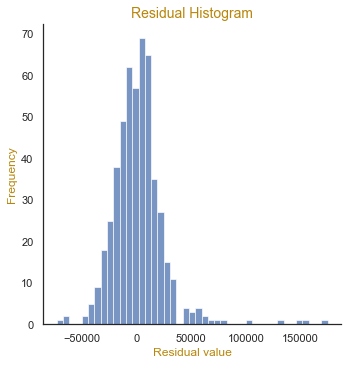

In [113]:
#check residual histogram
resid_hgram(ytest_sf, yhat_sf) 

In [114]:
X2_sf = sm.add_constant(X_sf)
project_model_sm = sm.OLS(y_sf, X2_sf)
res = project_model_sm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     667.9
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:43:28   Log-Likelihood:                 1298.6
No. Observations:                2043   AIC:                            -2539.
Df Residuals:                    2014   BIC:                            -2376.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.1563      0.036    281.462      0.000      10.086      10.227
overallqual         0.0706      0.004     18.550      0.000       0.063       0.078
overallcond         0.0401      0.003     13.021      0.000       0.034       0.046
totalbsmtsf         0.0001   1.12e-05      9.710      0.000    8.67e-05       0.000
kitchenqual         0.0384      0.007      5.739      0.000       0.025       0.051
paveddrive          0.0933      0.012      7.994      0.000       0.070       0.116
zone_FV             0.1917      0.027      6.979      0.000       0.138       0.246
zone_RL             0.1409      0.023      6.086      0.000       0.095       0.186
zone_RM             0.0740      0.024      3.147      0.002       0.028       0.120
lotshape_irr        0.0085      0.007      1.282      0.200      -0.004       0.021
near_busy_st       -0.0390      0.011     -3.691      0.000      -0.060      -0.018
non_1fam           -0.0265      0.011     -2.366      0.018      -0.048      -0.005
2plus_fl           -0.0341      0.009     -3.608      0.000      -0.053      -0.016
hip_roof            0.0216      0.008      2.762      0.006       0.006       0.037
ext_ord             0.0048      0.004      1.227      0.220      -0.003       0.012
has_veneer          0.0076      0.007      1.099      0.272      -0.006       0.021
cncrt_found         0.0554      0.009      5.980      0.000       0.037       0.074
bsmt_ord            0.0441      0.005      9.452      0.000       0.035       0.053
heatingqc_dum       0.0156      0.008      2.076      0.038       0.001       0.030
cent_air_dum        0.0691      0.013      5.208      0.000       0.043       0.095
garage_ord          0.0613      0.009      6.946      0.000       0.044       0.079
fireplace_ord       0.0342      0.006      5.717      0.000       0.022       0.046
lotfrontage_imp     0.0004      0.000      2.230      0.026    4.88e-05       0.001
remodel_age        -0.0007      0.000     -3.363      0.001      -0.001      -0.000
tot_bath            0.0372      0.006      6.355      0.000       0.026       0.049
deckporcharea    1.606e-05   2.26e-05      0.712      0.477   -2.82e-05    6.03e-05
nhood_3             0.0117      0.008      1.548      0.122      -0.003       0.026
lotarea_sf       5.667e-06   8.03e-07      7.057      0.000    4.09e-06    7.24e-06
grlivarea_sf        0.0002   1.12e-05     21.636      0.000       0.000       0.000
==============================================================================
Omnibus:                     1078.216   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31296.230
Skew:                          -1.910   Prob(JB):                         0.00
Kurtosis:                      21.790   Cond. No.                     1.85e+05


#### Extra Kaggle submission. The project model should be more interpretable but  might be slightly less accurate than the previous models. Check if that's true by getting the Kaggle score.

In [115]:
ames2['lotarea_sf'] = np.exp(ames2['lotarea'])
ames2['grlivarea_sf'] = np.exp(ames2['grlivarea'])
ames2_sf = ames2.copy()
ames2_sf.drop(['lotarea', 'grlivarea', 'nhood_1'], axis=1, inplace=True)
ames2.drop(['lotarea_sf', 'grlivarea_sf'], axis=1, inplace=True)

In [116]:

lr_kgl2 = LinearRegression().fit(X_sf, y_sf)
# get kaggle predictions. undo log-transformation of prices to get usable values
ames_kgl4  = ames2_sf.drop('id', axis=1)
yhat_kgl4 = np.exp(lr_kgl2.predict(ames_kgl4))

In [117]:
# convert to a dataframe again
yhat_kgl4=pd.DataFrame(yhat_kgl4, columns=['SalePrice'])
yhat_kgl4.head()

,SalePrice
0,134315.177250
1,164277.950317
2,217517.829820
3,100275.718303
4,168059.472502


In [118]:
# concatinate predictions with the id column and re-order to the format required
submit4 = pd.concat([id_column, yhat_kgl4], axis=1)
submit4.set_index('id', drop=True, inplace=True)
submit4.sort_values(by='id', inplace=True)
submit4.head()

,SalePrice
id,
2,97228.488667
4,270192.888255
6,198136.870362
7,210627.281610
17,217459.057438


In [119]:
# check the score!
submit4.to_csv('../datasets/kaggle4_project_model.csv')

#### the score, as expected, wasn't as good as previous models. it was better than other models on test data, but worse on kaggle data, so overall it's about on par with them.

In [120]:
av_price=np.exp(ames.saleprice).mean()

### taking a log of the dependent variable, but not of indepenent variables, has mathematical implications, especially on the meaning of regression coefficients. In a nutshell, with model like this one, the coefficients denote the following: they represent how much will be the percentage increase in the dependent based on the 1 unit increase in the independent variable.
- therefore, to get coefficients to be meaningful to business users, we will approximate their effect by multiplying them with the average house price. after doing that, we will see how much would a one unit increase in the independent variable increase the price of an average house.
- we chose not to simplify our model even more by not taking the log transformation of the price, as the model accuracy dropped too much.

<a id = '8.1'><a/>
### 8.1 Value-added per house feature
* [Back to top](#Content)

In [121]:
# create a dataframe with model coefficient, and their impact on the average house value,
# according to the data from our model
Coef_project_model = zip(X_sf.columns, np.around(av_price*lr_kgl2.coef_,2))
lst = list(Coef_project_model)
pm = pd.DataFrame(lst, columns = ['feature', 'value_added'])

In [122]:
pm

,feature,value_added
0,overallqual,12797.99
1,overallcond,7273.88
2,totalbsmtsf,19.71
3,kitchenqual,6956.46
4,paveddrive,16922.95
5,zone_FV,34759.89
6,zone_RL,25548.49
7,zone_RM,13423.28
8,lotshape_irr,1536.75
9,near_busy_st,-7078.06


In [123]:
# barplot showing dollar contribution to an average house per feature would be hard to read - it
# has too many features with vastly different dollar contribution amounts
# create 3 groups (and 3 charts) based on similar contribution size and category
quality_features = ['tot_bath', 'overallqual', 'overallcond', 'kitchenqual', 'ext_ord',
           'bsmt_ord', 'garage_ord', 'fireplace_ord', 'nhood_3']
size_features = ['totalbsmtsf', 'lotfrontage_imp', 'remodel_age', 'deckporcharea',
           'lotarea_sf', 'grlivarea_sf']
dummy_features = list(set(pm.feature.unique()) - set(quality_features) - set(size_features))

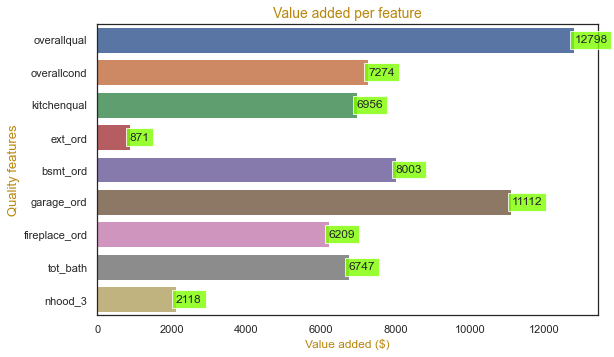

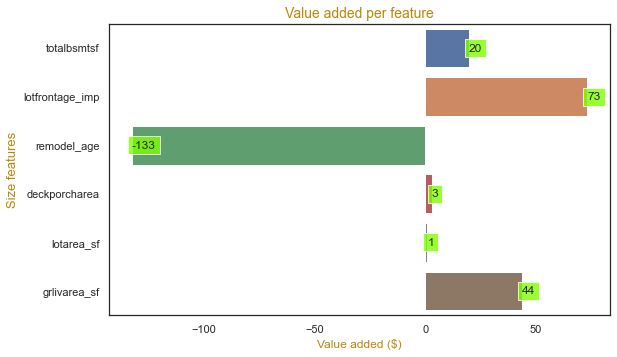

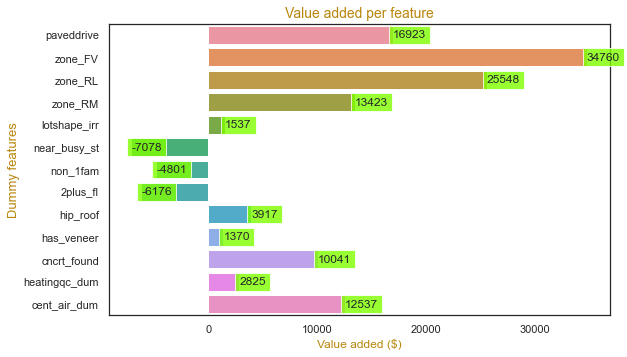

In [126]:
partial_hbar(quality_features, 'Quality features')
partial_hbar(size_features, 'Size features')
partial_hbar(dummy_features, 'Dummy features')

<a id = '9.0'><a/>
### 9.0 Outcomes and recommendations
* [Back to top](#Content)

**Outcomes**

- The first goal of this project is to create a pricing model for homes in Ames, IA that has a combination of accuracy and interpretibility. As far as the accuracy is concerned, we entered a few of our models into a Kaggle competition to see how they stack up versus the competition. Our top model, a 20-feature one with Ridge Regularization scored in the top 15 out of a myriad of submission, with a test rmse error of only 20,090 dollars.

- another successful outcome was that all of our models performed well, with an r2 of around 0.9, which shows that the good kaggle score was not due to the luck of stumbling into a right model with the right data, but rather, it was due to careful data selection and transformation

- as far as the model that will be presented to the stakeholders, we chose a somewhat simpler model with comparable rmse (better on test, worse on kaggle data) and with fewer transformation but with much more interpretibility and intuitive sense, which can easily produce results that can be used in day-to-day operations

**Recommendations:**

- the last model in this notebook with 28 features and charts of how each of these features affect the house price has the best of both worlds and can be used as the go-to model. With r2 of close to 0.9, rmse of 25k and easily made sense of due to few transformations, it is dependable, simple, easy to modify and ready for everyday use

- another reason why we chose this model despite the fact it doesn't have the lowest kaggle rmse  is that a pure data model of housing prices, devoid of human judgement, will never be perfect. No model on the Kaggle leaderboard was able to predict house prices to an average error of less than 15k dollars. This implies that no matter how complex and cutting-edge the model is, assessing the price will always be somewhat of an art. And since that is the case and a human input will be needed at some stage anyway, we were willing to sacrifice (potentially) a bit of accuracy for the sake of interpretibility.

- still, when the Fund finally starts to invest, the recommendation would be to switch models and use our most accurate one, as maximum accuracy is needed when deciding which house to invest in or which ones are underpriced. 

- once the funds are deployed and the homes are bought, it'll be time to look at which house features can be improved/upgraded to enhance the property's value:

a) while nothing can be done about the zoning, improvements in foundation of the house and central air can increase property value substantially (10k and 12k respectively)

b) it makes sense to build-out the house and cover up as much as the lot as possible. While it might not be aesthetically pleasing to some, the market values living area much more than lotarea (even after adjusting that lotarea is many times bigger than the living area - 44 vs 1 dollar per sf2)

c) investing into overall condition of the house and the garage can pay high dividents. An imporvement of 1 point on the condition scale can be worth more than 10000 dollars. Ofcourse, the cost must be assessed as well, but with such a high premium for improvement, doing it should be well worth it. 